### Google Colab routines

In [ ]:
from google.colab import files

files.upload() # uploading kaggle.json

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 597M/612M [00:05<00:00, 161MB/s]
100% 612M/612M [00:05<00:00, 114MB/s]


In [5]:
! mkdir gtsrb

In [6]:
! unzip gtsrb-german-traffic-sign.zip -d gtsrb > /dev/null

### Рассматриваемая задача классификации:

**Вход:** матрица формы `(3, 30, 30)` с вещественными числами от 0 до 1

**Выход:** вектор из 43 вероятностей

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
np.random.seed(987654321)

In [2]:
data_dir = 'gtsrb'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(data_dir + '/Train'))
NUM_CATEGORIES

43

Считаем все изображения и приведём их к нужному виду с помощью pillow.

In [4]:
train_image_data = []
train_labels = []

train_data = pd.read_csv(data_dir + "/Train.csv")

for label, image_path in list(zip(train_data["ClassId"], train_data["Path"])):
    image = Image.open(data_dir + '/' + image_path)
    resized_image = image.resize((IMG_HEIGHT, IMG_WIDTH))
    train_image_data.append(np.array(resized_image))
    train_labels.append(label)

train_image_data = np.moveaxis(np.array(train_image_data), -1, 1)
train_labels = np.array(train_labels)

print(f"shape of train_image_data: {train_image_data.shape}")
print(f"shape of train_labels: {train_labels.shape}")

shape of train_image_data: (39209, 3, 30, 30)
shape of train_labels: (39209,)


In [5]:
test_image_data = []
test_labels = []

test_data = pd.read_csv(data_dir + "/Test.csv")

for label, image_path in list(zip(test_data["ClassId"], test_data["Path"])):
    image = Image.open(data_dir + '/' + image_path)
    resized_image = image.resize((IMG_HEIGHT, IMG_WIDTH))
    test_image_data.append(np.array(resized_image))
    test_labels.append(label)

test_image_data = np.moveaxis(np.array(test_image_data), -1, 1)
test_labels = np.array(test_labels)

print(f"shape of test_image_data: {test_image_data.shape}")
print(f"shape of test_labels: {test_labels.shape}")

shape of test_image_data: (12630, 3, 30, 30)
shape of test_labels: (12630,)


Разделим датасет на три части:

- `X_train`, `y_train` — тренировка
- `X_val`, `y_val` — валидация
- `X_test`, `y_test` — тестирование

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_image_data, train_labels, test_size=0.3, random_state=42, shuffle=True)
X_test, y_test = test_image_data, test_labels

In [7]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [8]:
print(f"train - X: {X_train.shape}, y: {y_train.shape}")
print(f"validation - X: {X_val.shape}, y: {y_val.shape}")
print(f"test - X: {X_test.shape}, y: {y_test.shape}")

train - X: (27446, 3, 30, 30), y: (27446,)
validation - X: (11763, 3, 30, 30), y: (11763,)
test - X: (12630, 3, 30, 30), y: (12630,)


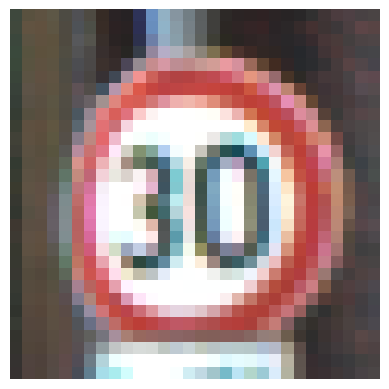

In [9]:
plt.imshow(np.moveaxis(X_test[1], 0, -1))
plt.axis('off')
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, classification_report

### 1. `sklearn.linear_model.LogisticRegression`

Воспользуемся самой простой доступной моделью, чтобы убедиться в корректности данных.

In [17]:
# to improve readability
import warnings
warnings.filterwarnings("ignore")

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
model_1 = LogisticRegression()

In [20]:
model_1.fit(X_train.reshape(X_train.shape[0], -1), y_train)

LogisticRegression()

In [21]:
print(f"train set accuracy: {accuracy_score(y_train, model_1.predict(X_train.reshape(X_train.shape[0], -1)))}")
print(f"validation set accuracy: {accuracy_score(y_val, model_1.predict(X_val.reshape(X_val.shape[0], -1)))}")
print(f"test set accuracy: {accuracy_score(y_test, model_1.predict(X_test.reshape(X_test.shape[0], -1)))}")

train set accuracy: 0.9383881075566567
validation set accuracy: 0.9184731786108986
test set accuracy: 0.8314330958036421


In [22]:
print(classification_report(y_test, model_1.predict(X_test.reshape(X_test.shape[0], -1))))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53        60
           1       0.69      0.90      0.78       720
           2       0.84      0.85      0.85       750
           3       0.78      0.66      0.71       450
           4       0.83      0.77      0.80       660
           5       0.69      0.82      0.75       630
           6       0.78      0.64      0.70       150
           7       0.84      0.65      0.73       450
           8       0.72      0.84      0.77       450
           9       0.93      0.86      0.89       480
          10       0.84      0.92      0.88       660
          11       0.86      0.87      0.87       420
          12       0.93      0.95      0.94       690
          13       0.96      0.98      0.97       720
          14       0.98      0.95      0.96       270
          15       0.80      0.87      0.83       210
          16       0.86      0.89      0.88       150
          17       0.98    

In [23]:
model_1_to_plot = LogisticRegression(max_iter=1, warm_start=True)

train_accuracy_1 = []
val_accuracy_1 = []

for it in range(100):
    model_1_to_plot.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    train_accuracy_1.append(accuracy_score(y_train, model_1_to_plot.predict(X_train.reshape(X_train.shape[0], -1))))
    val_accuracy_1.append(accuracy_score(y_val, model_1_to_plot.predict(X_val.reshape(X_val.shape[0], -1))))

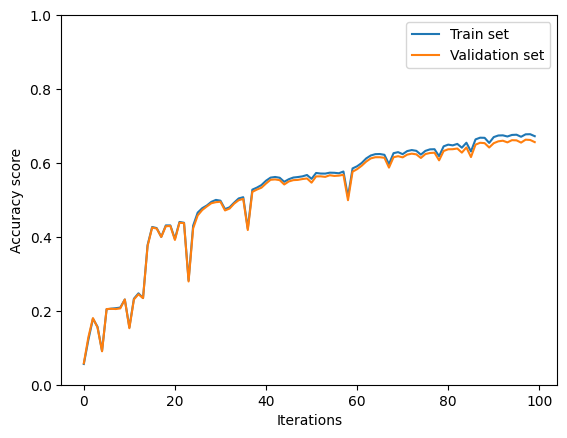

In [28]:
plt.plot(train_accuracy_1, label="Train set")
plt.plot(val_accuracy_1, label="Validation set")
plt.ylim([0, 1])
plt.xlabel("Iterations")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

### 2. Простейшая нейронная сеть

Будем использовать сеть с одним полносвязным слоем `torch.nn.Linear`.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [30]:
model_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(IMG_HEIGHT * IMG_WIDTH * channels, NUM_CATEGORIES),
    nn.LogSoftmax(dim=-1)
)

In [31]:
opt_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

Код тренировки по эпохам по большей части основан на https://pytorch.org/tutorials/beginner/introyt/trainingyt.html.

In [12]:
train_loader = torch.utils.data.DataLoader(list(zip(X_train.astype(np.float32), y_train)), batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(X_val.astype(np.float32), y_val)), batch_size=4, shuffle=False)

In [17]:
# just for convenience
def model_predict(model, X):
    return torch.argmax(model(torch.from_numpy(X.astype(np.float32))), dim=-1).detach().numpy()

In [14]:
def train_one_epoch(model, optimizer, train_accuracy, log_frequency=500):
    running_loss = 0.
    last_loss = 0.

    batch_outputs = np.array([])
    batch_labels = np.array([])

    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        batch_outputs = np.append(batch_outputs, torch.argmax(outputs, dim=-1).detach().numpy())
        batch_labels = np.append(batch_labels, labels)

        loss = F.nll_loss(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % log_frequency == log_frequency - 1:
            last_loss = running_loss / log_frequency
            train_accuracy.append(accuracy_score(batch_labels, batch_outputs))
            batch_outputs = np.array([])
            batch_labels = np.array([])
            print(f'  batch {i + 1} loss: {last_loss}')
            running_loss = 0.

    return last_loss

In [35]:
EPOCHS = 10

train_accuracy_2 = []
val_accuracy_2 = []

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    model_2.train(True)
    avg_loss = train_one_epoch(model_2, opt_2, train_accuracy_2)

    model_2.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs = model_2(vinputs)
        vloss = F.nll_loss(voutputs, vlabels)
        running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)

    val_accuracy_2.append(accuracy_score(y_val, model_predict(model_2, X_val)))

    print(f'LOSS train {avg_loss} val {avg_vloss}')

EPOCH 1:
  batch 500 loss: 3.3805066639184953
  batch 1000 loss: 2.546370512783527
  batch 1500 loss: 2.144913806810975
  batch 2000 loss: 1.9298179855644704
  batch 2500 loss: 1.7711078509949147
  batch 3000 loss: 1.6267732774131
  batch 3500 loss: 1.53663554020226
  batch 4000 loss: 1.3935600673300215
  batch 4500 loss: 1.4038380422592163
  batch 5000 loss: 1.3249889899417757
  batch 5500 loss: 1.2002244283035397
  batch 6000 loss: 1.169932091552997
  batch 6500 loss: 1.182246213530423
LOSS train 1.182246213530423 val 1.187963843345642
EPOCH 2:
  batch 500 loss: 1.0563735549313715
  batch 1000 loss: 0.9862479397833813
  batch 1500 loss: 1.0746069608211983
  batch 2000 loss: 0.9884709629938588
  batch 2500 loss: 0.9407374413684011
  batch 3000 loss: 0.9576912515058648
  batch 3500 loss: 0.8636823827733279
  batch 4000 loss: 0.9473599624184426
  batch 4500 loss: 0.8267730078582972
  batch 5000 loss: 0.949549242220819
  batch 5500 loss: 0.814699641160536
  batch 6000 loss: 0.84818333709

In [39]:
# saving data
torch.save(model_2, "model_2.pt")
np.savetxt("train_accuracy_2.txt", train_accuracy_2)
np.savetxt("val_accuracy_2.txt", val_accuracy_2)

In [13]:
# loading data
model_2 = torch.load("model_2.pt")
train_accuracy_2 = np.loadtxt("train_accuracy_2.txt")
val_accuracy_2 = np.loadtxt("val_accuracy_2.txt")

In [15]:
def plot_accuracy(train_accuracy, val_accuracy, log_frequency=500):
    plt.ylim([0, 1])
    plt.plot(np.arange(len(train_accuracy)), train_accuracy, color='orange', zorder=1)
    step = X_train.shape[0] // 4 // log_frequency
    plt.scatter(np.arange(step - 1, len(val_accuracy) * step + step - 1, step), val_accuracy, zorder=2)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy score")
    plt.show()

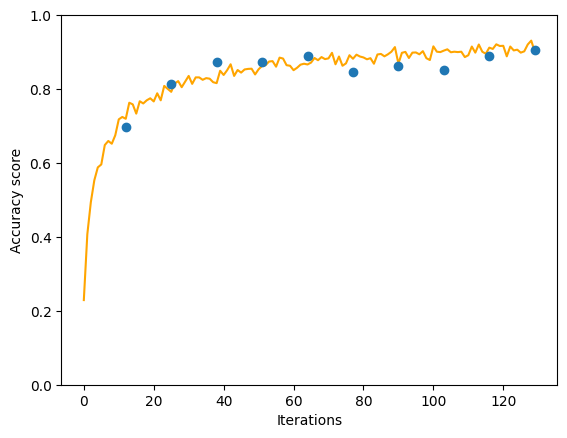

In [42]:
plot_accuracy(train_accuracy_2, val_accuracy_2)

In [43]:
print(f"train set accuracy: {accuracy_score(y_train, model_predict(model_2, X_train))}")
print(f"validation set accuracy: {accuracy_score(y_val, model_predict(model_2, X_val))}")
print(f"test set accuracy: {accuracy_score(y_test, model_predict(model_2, X_test))}")

train set accuracy: 0.9296800991036945
validation set accuracy: 0.9064864405338774
test set accuracy: 0.8085510688836105


### 3. Свёрточная сеть

Построим простую свёрточную сеть с одним свёрточным слоем и двумя полносвязными слоями.


In [45]:
model_3 = nn.Sequential(
    nn.Conv2d(channels, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(16),
    
    nn.Flatten(),
    nn.Linear(3136, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CATEGORIES),
    nn.LogSoftmax(dim=-1)
)

In [46]:
opt_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [47]:
EPOCHS = 5

train_accuracy_3 = []
val_accuracy_3 = []

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    model_3.train(True)
    avg_loss = train_one_epoch(model_3, opt_3, train_accuracy_3)

    model_3.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs = model_3(vinputs)
        vloss = F.nll_loss(voutputs, vlabels)
        running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)

    val_accuracy_3.append(accuracy_score(y_val, model_predict(model_3, X_val)))

    print(f'LOSS train {avg_loss} val {avg_vloss}')

EPOCH 1:
  batch 500 loss: 1.7718012127950789
  batch 1000 loss: 0.7415810123697556
  batch 1500 loss: 0.5810214040594291
  batch 2000 loss: 0.513805934425909
  batch 2500 loss: 0.47095470310411475
  batch 3000 loss: 0.3637403351532303
  batch 3500 loss: 0.3336354131663243
  batch 4000 loss: 0.3446688775351258
  batch 4500 loss: 0.37118949208801244
  batch 5000 loss: 0.23789983948548207
  batch 5500 loss: 0.2998908154873237
  batch 6000 loss: 0.3010321943229999
  batch 6500 loss: 0.29690851035964894
LOSS train 0.29690851035964894 val 0.33093035221099854
EPOCH 2:
  batch 500 loss: 0.1383922700828556
  batch 1000 loss: 0.15817427220887748
  batch 1500 loss: 0.13689115802704158
  batch 2000 loss: 0.1721165861995296
  batch 2500 loss: 0.18188970677210917
  batch 3000 loss: 0.17985936984059425
  batch 3500 loss: 0.17849057515743352
  batch 4000 loss: 0.20055232706950188
  batch 4500 loss: 0.1465390660354132
  batch 5000 loss: 0.16567326115590653
  batch 5500 loss: 0.15117943608699766
  batc

In [48]:
# saving data
torch.save(model_3, "model_3.pt")
np.savetxt("train_accuracy_3.txt", train_accuracy_3)
np.savetxt("val_accuracy_3.txt", val_accuracy_3)

In [15]:
# loading data
model_3 = torch.load("model_3.pt")
train_accuracy_3 = np.loadtxt("train_accuracy_3.txt")
val_accuracy_3 = np.loadtxt("val_accuracy_3.txt")

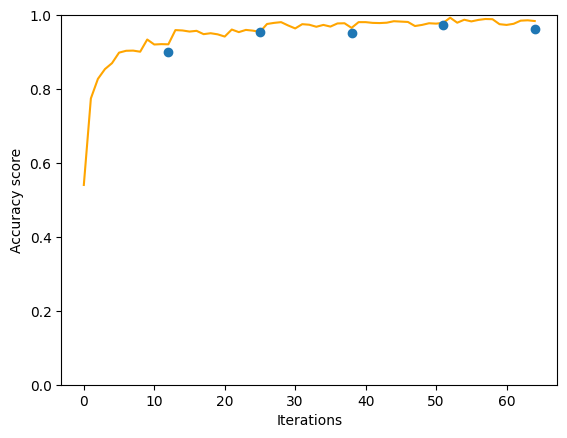

In [49]:
plot_accuracy(train_accuracy_3, val_accuracy_3)

In [50]:
print(f"train set accuracy: {accuracy_score(y_train, model_predict(model_3, X_train))}")
print(f"validation set accuracy: {accuracy_score(y_val, model_predict(model_3, X_val))}")
print(f"test set accuracy: {accuracy_score(y_test, model_predict(model_3, X_test))}")

train set accuracy: 0.9810537054579902
validation set accuracy: 0.9616594406188897
test set accuracy: 0.879889152810768


In [51]:
print(classification_report(y_test, model_predict(model_3, X_test)))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66        60
           1       0.68      0.98      0.80       720
           2       0.87      0.87      0.87       750
           3       0.77      0.71      0.74       450
           4       0.94      0.84      0.89       660
           5       0.75      0.76      0.75       630
           6       0.95      0.84      0.89       150
           7       0.94      0.81      0.87       450
           8       0.85      0.89      0.87       450
           9       0.97      0.94      0.95       480
          10       0.96      0.96      0.96       660
          11       0.84      0.90      0.87       420
          12       0.98      0.96      0.97       690
          13       0.99      0.95      0.97       720
          14       1.00      0.94      0.97       270
          15       0.96      0.98      0.97       210
          16       0.99      0.97      0.98       150
          17       0.99    

### 4. Свёрточная сеть strikes again

Построим свёрточную сеть с двумя свёрточными слоями и двумя полносвязными слоями.


In [17]:
model_4 = nn.Sequential(
    nn.Conv2d(channels, 16, 3),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),
    
    nn.Flatten(),
    nn.Linear(5408, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CATEGORIES),
    nn.LogSoftmax(dim=-1)
)

In [18]:
opt_4 = torch.optim.Adam(model_4.parameters(), lr=0.001)

In [19]:
EPOCHS = 5

train_accuracy_4 = []
val_accuracy_4 = []

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    model_4.train(True)
    avg_loss = train_one_epoch(model_4, opt_4, train_accuracy_4)

    model_4.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs = model_4(vinputs)
        vloss = F.nll_loss(voutputs, vlabels)
        running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)

    val_accuracy_4.append(accuracy_score(y_val, model_predict(model_4, X_val)))

    print(f'LOSS train {avg_loss} val {avg_vloss}')

EPOCH 1:
  batch 500 loss: 2.0209501111647112
  batch 1000 loss: 0.7506200704327785
  batch 1500 loss: 0.5030359388148645
  batch 2000 loss: 0.37494198760367
  batch 2500 loss: 0.3134895681551561
  batch 3000 loss: 0.24586462798615322
  batch 3500 loss: 0.24648858285104824
  batch 4000 loss: 0.1674171926434626
  batch 4500 loss: 0.16356023436218925
  batch 5000 loss: 0.2217566369592091
  batch 5500 loss: 0.1723836323662403
  batch 6000 loss: 0.22184024030715802
  batch 6500 loss: 0.13905568753739886
LOSS train 0.13905568753739886 val 0.16736742854118347
EPOCH 2:
  batch 500 loss: 0.06905081266784718
  batch 1000 loss: 0.14171672060347487
  batch 1500 loss: 0.0995036649668919
  batch 2000 loss: 0.1086607905670775
  batch 2500 loss: 0.10717897694489095
  batch 3000 loss: 0.1097908900918672
  batch 3500 loss: 0.14202034567190616
  batch 4000 loss: 0.10441702041229484
  batch 4500 loss: 0.13224915303482113
  batch 5000 loss: 0.1107036685624049
  batch 5500 loss: 0.08470942919718415
  batch

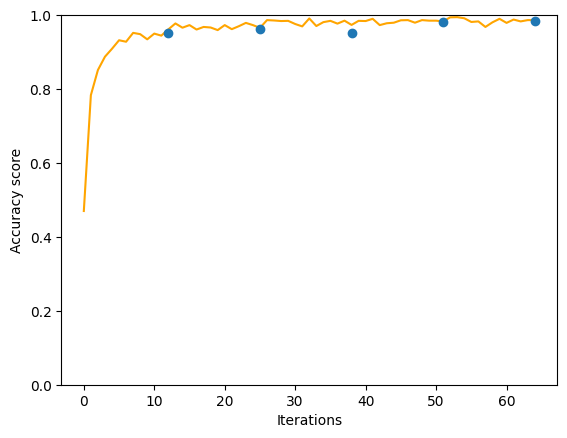

In [20]:
plot_accuracy(train_accuracy_4, val_accuracy_4)

In [21]:
# saving data
torch.save(model_4, "model_4.pt")
np.savetxt("train_accuracy_4.txt", train_accuracy_4)
np.savetxt("val_accuracy_4.txt", val_accuracy_4)

In [14]:
# loading data
model_4 = torch.load("model_4.pt")
train_accuracy_4 = np.loadtxt("train_accuracy_4.txt")
val_accuracy_4 = np.loadtxt("val_accuracy_4.txt")

In [18]:
print(f"train set accuracy: {accuracy_score(y_train, model_predict(model_4, X_train))}")
print(f"validation set accuracy: {accuracy_score(y_val, model_predict(model_4, X_val))}")
print(f"test set accuracy: {accuracy_score(y_test, model_predict(model_4, X_test))}")

train set accuracy: 0.9956642133644247
validation set accuracy: 0.9840176825639718
test set accuracy: 0.9422802850356294


In [19]:
print(classification_report(y_test, model_predict(model_4, X_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94        60
           1       0.94      0.95      0.94       720
           2       0.93      0.98      0.96       750
           3       0.97      0.90      0.93       450
           4       0.96      0.97      0.97       660
           5       0.82      0.95      0.88       630
           6       0.97      0.73      0.83       150
           7       0.97      0.84      0.90       450
           8       0.89      0.92      0.90       450
           9       0.96      1.00      0.98       480
          10       0.98      0.97      0.97       660
          11       0.96      0.90      0.93       420
          12       0.99      0.99      0.99       690
          13       1.00      0.99      0.99       720
          14       0.99      0.99      0.99       270
          15       0.97      1.00      0.98       210
          16       0.99      0.97      0.98       150
          17       0.99    

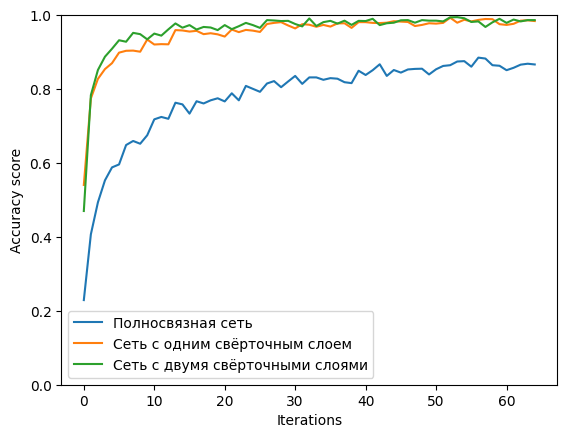

In [22]:
plt.ylim([0, 1])
ITERATIONS = 5 * 13
plt.plot(np.arange(ITERATIONS), train_accuracy_2[:ITERATIONS], label="Полносвязная сеть")
plt.plot(np.arange(ITERATIONS), train_accuracy_3[:ITERATIONS], label="Сеть с одним свёрточным слоем")
plt.plot(np.arange(ITERATIONS), train_accuracy_4[:ITERATIONS], label="Сеть с двумя свёрточными слоями")
plt.xlabel("Iterations")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()